### Imports

In [129]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Move two directories up to reach the parent directory of 'Projects'
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [130]:
from datasets.traffic_signs_preprocessed.datasets_preparing import *
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2

### Previewing Original Dataset

In [131]:
import os
print(os.getcwd())

/Users/sudharsangopalakrishnan/SmarTransit/Projects/Traffic Signal Classification


In [132]:
# Assume the current directory is 'Projects/P1'
# Move up two directories and then specify the path to the pickle file
with open("../../datasets/traffic_signs_preprocessed/data0.pickle", "rb") as f:
    data = pickle.load(f)

In [133]:
data.keys()

dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])

In [134]:
X_train = data["x_train"]
X_valid = data["x_validation"]
X_test = data["x_test"]

y_train = data["y_train"]
y_valid = data["y_validation"]
y_test = data["y_test"]

In [135]:
type(X_valid)

numpy.ndarray

In [136]:
X_train.shape, X_valid.shape, X_test.shape

((86989, 3, 32, 32), (4410, 3, 32, 32), (12630, 3, 32, 32))

In [137]:
total_size = len(X_train) + len(X_valid) + len(X_test)
train_prp = len(X_train) / total_size
valid_prp = len(X_valid) / total_size
test_prp = len(X_test) / total_size
print("Data Summary")
print("------------")
print(f"Train: {train_prp*100:.2f}%\nValid: {valid_prp*100:.2f}%\nTest: {test_prp*100:.2f}%")

Data Summary
------------
Train: 83.62%
Valid: 4.24%
Test: 12.14%


In [138]:
label_list = label_text("../../datasets/traffic_signs_preprocessed/label_names.csv")

In [139]:
def plot_sample_image(X_train, y_train, label_list, index, alpha=1.5, beta=10):
    image = np.transpose(X_train[index], (1, 2, 0))

    # call convertScaleAbs function
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    sns.set_style("whitegrid")
    plt.imshow(adjusted)
    plt.title(f"Sign: {label_list[y_train[index]]}")
    plt.show()

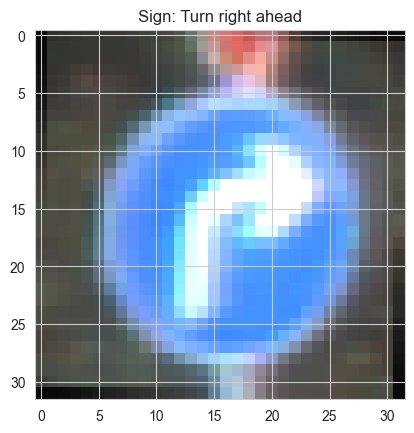

In [140]:
plot_sample_image(X_train, y_train, label_list, index=209, alpha=1.5, beta=10)

### Prepare Data

In [ ]:
# Train, Valid, Test Files
train_file = "../../datasets/traffic_signs_preprocessed/train.pickle"
valid_file = "../../datasets/traffic_signs_preprocessed/valid.pickle"
test_file = "../../datasets/traffic_signs_preprocessed/test.pickle"

In [ ]:
X_train, y_train, s_train, c_train = load_rgb_data(train_file)
X_valid, y_valid, s_valid, c_valid = load_rgb_data(valid_file)
X_test, y_test, s_test, c_test = load_rgb_data(test_file)

In [ ]:
total_size = len(X_train) + len(X_valid) + len(X_test)
train_prp = len(X_train) / total_size
valid_prp = len(X_valid) / total_size
test_prp = len(X_test) / total_size
print("Data Summary")
print("------------")
print(f"Train: {train_prp*100:.2f}%\nValid: {valid_prp*100:.2f}%\nTest: {test_prp*100:.2f}%")

### Prepare Dataset

In [145]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from skimage.transform import resize

In [162]:
class TrafficDataset(Dataset):
    def __init__(self, file, X_size, y_size, type):
        self.file = file
        self.X_size = X_size
        self.y_size = y_size
        
        with open(self.file, 'rb') as f:
            self.data = pickle.load(f)
       
        self.X = None
        self.y = None
        if type=="train":
            self.X = self.data["x_train"]
            self.y = self.data["y_train"]
        elif type=="valid":
            self.X = self.data["x_validation"]
            self.y = self.data["y_validation"]
        elif type=="test":
            self.X = self.data["x_test"]
            self.y = self.data["y_test"]

        self.length = len(self.X)
    
    def __len__(self):
        return self.length

    def __getitem__(self, ix):
        image = self.X[ix]
        image_resized = resize(image, (3, self.X_size, self.y_size))
        return torch.tensor(image_resized).float().to(device), torch.tensor(self.y[ix]).float().to(device)
    
    # def __str__(self):
    #     total_size = len(self.X_train) + len(self.X_valid) + len(self.X_test)
    #     train_prp = len(self.X_train) / total_size
    #     valid_prp = len(self.X_valid) / total_size
    #     test_prp = len(self.X_test) / total_size
    #     return f"Data Summary\n------------\nTrain: {train_prp*100:.2f}%\nValid: {valid_prp*100:.2f}%\nTest: {test_prp*100:.2f}%"

In [152]:
file = "../../datasets/traffic_signs_preprocessed/data3.pickle"
X_size = 224
y_size = 224

td = TrafficDataset(file=file, X_size=X_size, y_size=y_size)

In [153]:
print(td)

Data Summary
------------
Train: 83.62%
Valid: 4.24%
Test: 12.14%


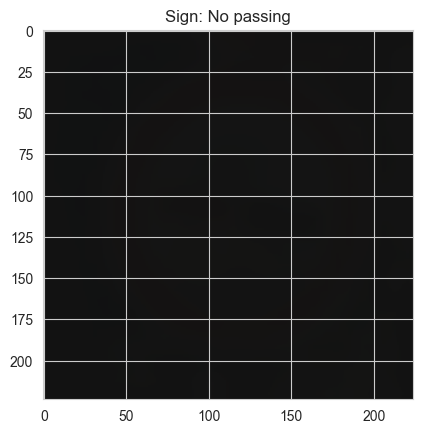

In [154]:
index = 1000
image = td[index][0].numpy()
image = np.transpose(image, (1, 2, 0))
adjusted = cv2.convertScaleAbs(image, alpha=2.5, beta=20)
sns.set_style("whitegrid")
plt.imshow(adjusted)
plt.title(f"Sign: {label_list[int(td[index][1].item())]}")
plt.show()

### Load VGG Model

In [155]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [160]:
def get_model():
    model = models.vgg16(pretrained=True).to(device)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128, 1),
                                   nn.Sigmoid())

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [161]:
input_size = (3, 224, 224)
model, criterion, optimizer = get_model()
summary(model, input_size=input_size)

/Users/sudharsangopalakrishnan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sudharsangopalakrishnan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()